In [1]:
import gc
import math
from time import time_ns

import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from tqdm import tqdm

if True:
    sin = np.sin
    cos = np.cos
else:
    sin = math.sin
    cos = math.cos

In [2]:
def base_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        if idx % 2 == 0:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

def base(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = base_dummy(d[idx])
    return r

In [3]:
@nb.njit
def njited_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        if idx % 2 == 0:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.njit
def njited(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = njited_dummy(d[idx])
    return r

In [4]:
@nb.njit(inline = 'always')
def njited_inline_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        if idx % 2 == 0:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.njit
def njited_inline(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = njited_inline_dummy(d[idx])
    return r

In [5]:
@nb.njit
def njited_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        if idx % 2 == 0:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.njit(parallel = True)
def njited_parallel(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = njited_parallel_dummy(d[idx])
    return r

In [6]:
@nb.njit
def vectorized_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        if idx % 2 == 0:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize
def vectorized(d: float) -> float:
    return vectorized_dummy(d)

In [7]:
funcs = [
    base,
    njited,
    njited_inline,
    njited_parallel,
    vectorized,
]

In [8]:
def test_all(size = 100):
    
    data = np.random.random(size) * 100
    res_base = funcs[0](data)
    
    for func in funcs[1:]:
        res = func(data)
        assert np.allclose(res_base, res)
        
test_all()

In [11]:
def benchmark(start = 4, stop = 14, reps = 5):  # 26
    sizes = (2 ** np.arange(start, stop + 0.5, 0.5)).astype('i8')
    results = {func.__name__: [] for func in funcs[1:]}
    gc.disable()
    for size in tqdm(sizes):
        data = np.random.random(size) * 100
        for func in funcs[1:]:  # exclude pure python
            runtimes = []
            for rep in range(reps):
                gc.collect()
                start = time_ns()
                _ = func(data)
                runtime = time_ns() - start
                runtimes.append(runtime)
            results[func.__name__].append(min(runtimes) * 1e-9)
    gc.enable()
    return sizes, results

s, r = benchmark()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.29it/s]


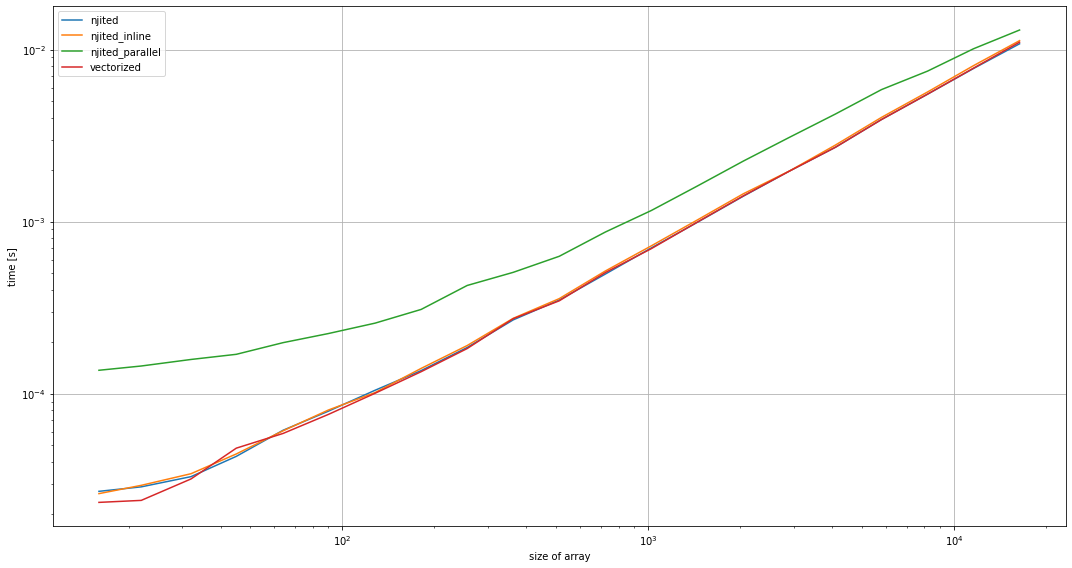

In [12]:
def plot(sizes, results):
    fig, ax = plt.subplots(figsize = (15, 8))
    for name, values in results.items():
        ax.loglog(sizes, values, label = name)
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('time [s]')
    ax.grid()
    fig.tight_layout()

plot(s, r)